In [10]:
# Imports
import osmnx as ox
import networkx as nx
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import pandas as pd
from geopy.geocoders import Nominatim

# for bus functions
from shapely.geometry import Point
from shapely.ops import unary_union
import random

In [6]:
class CalgaryTSP:
    def __init__(self):
        self.locations_bbox = None
        self.geolocator = Nominatim(user_agent="calgary_tsp")
        
        # Define main transit hubs
        self.transit_hubs = {
            'C-Train Stations': [
                ("Downtown West/Kerby", 51.0461, -114.0833),
                ("8th Street SW", 51.0461, -114.0789),
                ("7th Street SW", 51.0461, -114.0744),
                ("6th Street SW", 51.0461, -114.0700),
                ("3rd Street SW", 51.0461, -114.0567),
                ("City Hall", 51.0461, -114.0522),
                ("Erlton/Stampede", 51.0328, -114.0517),
                ("39th Avenue", 51.0219, -114.0517),
                ("Chinook", 50.9967, -114.0517),
                ("Heritage", 50.9883, -114.0517),
                ("Southland", 50.9633, -114.0517),
                ("Anderson", 50.9567, -114.0517),
                ("SAIT/ACAD/Jubilee", 51.0644, -114.0892),
                ("Lions Park", 51.0711, -114.0892),
                ("University", 51.0794, -114.1231),
                ("Brentwood", 51.0867, -114.1231),
                ("Dalhousie", 51.1042, -114.1231),
                ("Crowfoot", 51.1217, -114.1231),
                ("Tuscany", 51.1269, -114.2247)
            ],
            'Major Bus Terminals': [
                ("North Pointe Terminal", 51.1642, -114.0694),
                ("Brentwood Station", 51.0867, -114.1231),
                ("Lions Park Station", 51.0711, -114.0892),
                ("Anderson Station", 50.9567, -114.0517),
                ("Heritage Station", 50.9883, -114.0517),
                ("South Campus Hospital", 51.0794, -114.1231),
                ("Chinook Station", 50.9967, -114.0517)
            ]
        }
        
    def initialize_graph(self, locations):
        """Initialize graph based on locations"""
        # Get coordinates for all locations
        coords = []
        for loc in locations:
            location = self.geolocator.geocode(f"{loc}, Calgary, Alberta")
            if location:
                coords.append((location.latitude, location.longitude))
        
        # Add transit hub coordinates
        for hub_type in self.transit_hubs.values():
            for _, lat, lon in hub_type:
                coords.append((lat, lon))
        
        if not coords:
            raise ValueError("No valid locations found")
            
        # Calculate bounding box with padding
        min_lat = min(c[0] for c in coords)
        max_lat = max(c[0] for c in coords)
        min_lon = min(c[1] for c in coords)
        max_lon = max(c[1] for c in coords)
        
        # Add padding (about 20% of the range)
        lat_padding = (max_lat - min_lat) * 0.2
        lon_padding = (max_lon - min_lon) * 0.2
        
        self.locations_bbox = [
            min_lat - lat_padding,
            min_lon - lon_padding,
            max_lat + lat_padding,
            max_lon + lon_padding
        ]
        
        # Download graph for the specific area
        self.G = ox.graph_from_bbox(
            self.locations_bbox[0], self.locations_bbox[2],
            self.locations_bbox[1], self.locations_bbox[3],
            network_type='drive'
        )
        self.G_proj = ox.project_graph(self.G)

    def get_node_coordinates(self, address):
        """Get the nearest node coordinates for a given address"""
        try:
            location = self.geolocator.geocode(f"{address}, Calgary, Alberta")
            if location:
                nearest_node = ox.nearest_nodes(self.G, location.longitude, location.latitude)
                return nearest_node, (location.latitude, location.longitude)
        except Exception as e:
            print(f"Error geocoding {address}: {e}")
            return None, None

    def calculate_route_distance(self, node1, node2):
        """Calculate the actual driving distance between two nodes"""
        try:
            route = nx.shortest_path(self.G_proj, node1, node2, weight='length')
            return sum(ox.utils_graph.get_route_edge_attributes(self.G_proj, route, 'length'))
        except nx.NetworkXNoPath:
            return float('inf')

    def solve_tsp(self, locations):
        """Solve TSP for given locations"""
        self.initialize_graph(locations)
        
        nodes = []
        coords = []
        
        for loc in locations:
            node, coord = self.get_node_coordinates(loc)
            if node:
                nodes.append(node)
                coords.append(coord)
        
        n = len(nodes)
        if n < 2:
            return None, None, None
            
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    distances[i][j] = self.calculate_route_distance(nodes[i], nodes[j])
                    
        best_distance = float('inf')
        best_route = None
        
        for route in permutations(range(n)):
            distance = sum(distances[route[i]][route[(i+1)%n]] for i in range(n))
            if distance < best_distance:
                best_distance = distance
                best_route = route
                
        return best_route, best_distance, nodes

    def plot_solution(self, locations, best_route, nodes):
        """Plot the solution with transit hubs"""
        plt.figure(figsize=(15, 10))
        ax = plt.axes([0.1, 0.1, 0.75, 0.8])
        
        # Plot base map
        ox.plot_graph(self.G, ax=ax, show=False, close=False, 
                     edge_color='gray', edge_alpha=0.2, node_size=0)
        
        # Plot routes
        colors = plt.cm.rainbow(np.linspace(0, 1, len(best_route)))
        legend_elements = []
        
        for i in range(len(best_route)):
            start = best_route[i]
            end = best_route[(i+1) % len(best_route)]
            
            route = nx.shortest_path(self.G, nodes[start], nodes[end], weight='length')
            
            route_coords = []
            for node in route:
                node_data = self.G.nodes[node]
                route_coords.append((node_data['y'], node_data['x']))
            route_coords = np.array(route_coords)
            
            line = ax.plot(route_coords[:, 1], route_coords[:, 0], 
                         color=colors[i], linewidth=2, alpha=0.7)[0]
            legend_elements.append((line, f'{locations[start]} → {locations[end]}'))
        
        # Plot location markers
        for i, route_idx in enumerate(best_route):
            loc = locations[route_idx]
            coord = self.geolocator.geocode(f"{loc}, Calgary, Alberta")
            if coord:
                ax.plot(coord.longitude, coord.latitude, 'o', 
                       color='red', markersize=10, zorder=5)
                ax.annotate(f"{i+1}. {loc}", 
                          xy=(coord.longitude, coord.latitude),
                          xytext=(5, 5), textcoords='offset points',
                          bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        # Plot transit hubs
        for hub_type, hubs in self.transit_hubs.items():
            if hub_type == 'C-Train Stations':
                marker = '^'  # triangle for C-Train
                color = 'blue'
                size = 8
            else:
                marker = 's'  # square for bus terminals
                color = 'green'
                size = 8
                
            # Plot each hub
            for name, lat, lon in hubs:
                ax.plot(lon, lat, marker, 
                       color=color, markersize=size, zorder=4,
                       label=hub_type if name == hubs[0][0] else "")
                
                # Add small labels for transit hubs
                ax.annotate(name, 
                          xy=(lon, lat),
                          xytext=(3, 3), 
                          textcoords='offset points',
                          fontsize=8,
                          bbox=dict(facecolor='white', 
                                  edgecolor='none', 
                                  alpha=0.7))
        
        # Create legend
        route_legend = [line for line, label in legend_elements]
        route_labels = [label for line, label in legend_elements]
        
        # Combine all legend elements
        ax.legend(route_legend + 
                 [plt.Line2D([0], [0], marker='^', color='blue', linestyle='none'),
                  plt.Line2D([0], [0], marker='s', color='green', linestyle='none')],
                 route_labels + ['C-Train Stations', 'Bus Terminals'],
                 bbox_to_anchor=(1.05, 1), loc='upper left',
                 borderaxespad=0.)
        
        plt.title("Optimal Route through Calgary Neighborhoods\nwith Transit Hubs")
        plt.tight_layout()
        plt.show()

In [8]:
## Transit Hub Functions
def generate_random_points(center, radius, num_points):
    """Generate random points around a center within a radius."""
    random_points = []
    for _ in range(num_points):
        # Generate random distance and angle
        distance = random.uniform(0, radius)
        angle = random.uniform(0, 2 * np.pi)
        
        # Calculate new coordinates
        new_lat = center[0] + (distance / 111) * np.cos(angle)
        new_lon = center[1] + (distance / (111 * np.cos(np.radians(center[0])))) * np.sin(angle)
        
        random_points.append((new_lat, new_lon))
    return random_points

def map_pickups_to_hub(hub_name, num_pickups, pickup_radius, given_pickups=None):
    """Map best route for pickups to a transit hub."""
    solver = CalgaryTSP()
    
    # Find the hub coordinates
    hub_coords = None
    for hub_list in solver.transit_hubs.values():
        for hub in hub_list:
            if hub[0] == hub_name:
                hub_coords = (hub[1], hub[2])
                break
        if hub_coords:
            break
    
    if not hub_coords:
        print(f"Transit hub {hub_name} not found.")
        return
    
    # Generate or use given pickups
    if given_pickups is None:
        print("Generating random pickup locations...")
        pickups = generate_random_points(hub_coords, pickup_radius, num_pickups)
    else:
        pickups = given_pickups

    # Convert pickups to addresses if necessary
    locations = [f"Pickup {i+1}" for i in range(len(pickups))] + [hub_name]
    coords = pickups + [hub_coords]
    
    print("Calculating optimal route...")
    solver.initialize_graph(locations)
    nodes = [solver.get_node_coordinates(f"{coord[0]},{coord[1]}") for coord in coords]
    nodes = [n[0] for n in nodes if n[0]]  # Filter valid nodes
    
    if len(nodes) < 2:
        print("Not enough valid locations for a route.")
        return
    
    best_route, total_distance, _ = solver.solve_tsp(locations)
    if best_route is None:
        print("Couldn't find valid route.")
        return
    
    print("\nOptimal Route:")
    for idx in best_route:
        print(locations[idx])
    print(f"Total Distance: {total_distance / 1000:.2f} km")
    
    print("\nVisualizing the solution...")
    solver.plot_solution(locations, best_route, nodes)


In [12]:
map_pickups_to_hub("Chinook", 2, 3)

Generating random pickup locations...
Calculating optimal route...


C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:75: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  self.G = ox.graph_from_bbox(
C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:75: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  self.G = ox.graph_from_bbox(


TypeError: 'NoneType' object is not subscriptable

Calculating optimal route...


C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:75: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  self.G = ox.graph_from_bbox(
C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:75: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  self.G = ox.graph_from_bbox(
C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:97: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return sum(ox.utils_graph.get_route_edge_attributes(self.G_proj, route, 'length'))



Optimal Route:
-------------
1. Downtown Core, Calgary
2. Kensington, Calgary
3. University Heights, Calgary
4. Bowness, Calgary
5. Signal Hill, Calgary
6. Beltline, Calgary
7. Inglewood, Calgary
8. Bridgeland, Calgary

Total Distance: 42.07 km

Generating map visualization...


C:\Users\bilal\AppData\Local\Temp\ipykernel_38936\935574263.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


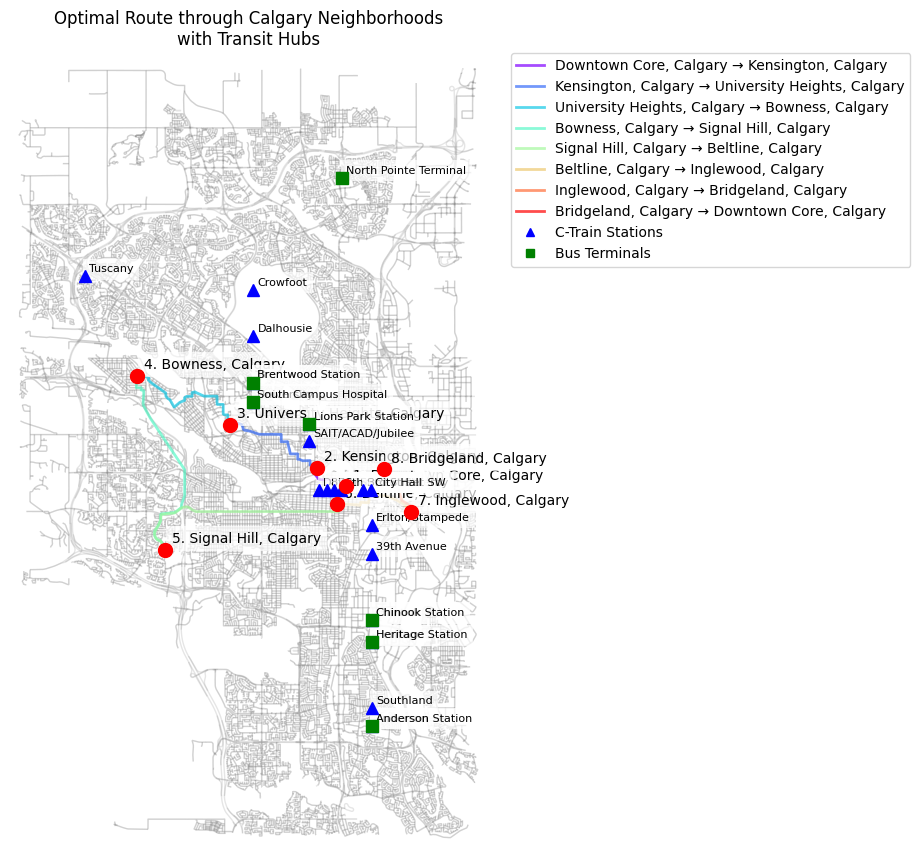

In [7]:
def main():
    locations = [
        "Downtown Core, Calgary",
        "Kensington, Calgary",
        "Beltline, Calgary",
        "Bowness, Calgary",
        "Inglewood, Calgary",
        "University Heights, Calgary",
        "Signal Hill, Calgary",
        "Bridgeland, Calgary"
    ]
    
    solver = CalgaryTSP()
    
    print("Calculating optimal route...")
    best_route, total_distance, nodes = solver.solve_tsp(locations)
    
    if best_route is None:
        print("Couldn't find valid route")
        return
        
    print("\nOptimal Route:")
    print("-------------")
    for i, idx in enumerate(best_route):
        print(f"{i+1}. {locations[idx]}")
    print(f"\nTotal Distance: {total_distance/1000:.2f} km")
    
    print("\nGenerating map visualization...")
    solver.plot_solution(locations, best_route, nodes)

if __name__ == "__main__":
    main()